<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>

</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 1
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

In [ ]:
name = "AmirHossein Naghdi"
studentId = "400102169"

It is recommended to open this notebook in Google Colab from [here](https://colab.research.google.com/drive/1tPrFiVeEtt76GIoImPOuv7NA9hKorlue?usp=sharing) and create a copy. You can comment your questions on the notebook as well.

In this exercise we want to gain hands-on experience with Normalizing Flow Models.
1. We want to implement a simple flow model from scratch. (GPU not required)
2. We will use a flow model to perform image in-painting. (GPU recommended)

# Section 1: Flow From Scratch

In [1]:
# @title imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.distributions as D

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import seaborn as sns
import torchvision as tv

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # you can change this if you like

One of the challenges in creating flow models is creating invertible transformations. Also we would like it if computation of their inverse and/or the log determinant of their jacobian were simple.

In [3]:
# @title base transform abstract class

class InverseNotAvailable(Exception):
    """Exception to be thrown when a transform does not have an inverse."""

    pass

class Transform(nn.Module):
    """Base class for all transform objects."""

    def forward(self, inputs, context=None):
        raise NotImplementedError()

    def inverse(self, inputs, context=None):
        raise InverseNotAvailable()


First we can create a random permutation transform

In [4]:
class PermutationTransform(Transform):
    def __init__(self, num_features):
        super().__init__()
        permutation = torch.randperm(num_features)
        self.register_buffer('permutation', permutation)
        self.register_buffer('inverse_permutation', torch.argsort(permutation))

    def forward(self, inputs, context=None):
        return inputs[:, self.permutation], 0  # Log-det is zero

    def inverse(self, inputs, context=None):
        return inputs[:, self.inverse_permutation]

Now  lets create a simple Coupling Transform.

In [38]:
import torch
import torch.nn as nn

class CouplingTransform(nn.Module):
    def __init__(self, mask, hidden_units, scale_network_fn=None, translate_network_fn=None):
        """
        Args:
            mask (1D Tensor): Defines which inputs are transformed or passed through unchanged.
            hidden_units (int): Number of hidden units in the neural networks.
            scale_network_fn (callable): Function to create the scaling network.
            translate_network_fn (callable): Function to create the translation network.
        """
        super().__init__()

        # Ensure mask is a valid 1D tensor
        mask = torch.as_tensor(mask, dtype=torch.float32)
        if mask.dim() != 1:
            raise ValueError("Mask must be a 1-dimensional tensor.")
        if mask.numel() <= 0:
            raise ValueError("Mask cannot be empty.")

        self.register_buffer("mask", mask)
        self.num_features = mask.numel()

        # Compute input and output dimensions for the networks
        input_dim = int((1 - mask).sum().item())
        output_dim = int(mask.sum().item())

        # Initialize scaling and translation networks
        self.scale_net = (scale_network_fn or self._default_network)(input_dim, output_dim, hidden_units)
        self.translate_net = (translate_network_fn or self._default_network)(input_dim, output_dim, hidden_units)

    @staticmethod
    def _default_network(input_dim, output_dim, hidden_units):
        """Default fully connected network."""
        return nn.Sequential(
            nn.Linear(input_dim, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units, output_dim),
        )

    def forward(self, inputs, context=None):
        self._validate_inputs(inputs)

        # Inputs masked for network computation
        input_pass = inputs * (1 - self.mask)
        masked_input = input_pass[:, self.mask == 0]

        # Compute scaling (s) and translation (t)
        scale = torch.tanh(self.scale_net(masked_input)) * self.mask
        translate = self.translate_net(masked_input) * self.mask

        # Transform inputs
        transformed = input_pass + self.mask * (inputs * torch.exp(scale) + translate)
        log_det_jacobian = scale.sum(dim=1)

        return transformed, log_det_jacobian

    def inverse(self, inputs, context=None):
        self._validate_inputs(inputs)

        # Inputs masked for network computation
        input_pass = inputs * (1 - self.mask)
        masked_input = input_pass[:, self.mask == 0]

        # Compute scaling (s) and translation (t)
        scale = torch.tanh(self.scale_net(masked_input)) * self.mask
        translate = self.translate_net(masked_input) * self.mask

        # Invert transformation
        inverted = input_pass + self.mask * (inputs - translate) * torch.exp(-scale)

        return inverted

    def _validate_inputs(self, inputs):
        """Validate input tensor dimensions."""
        if inputs.dim() != 2:
            raise ValueError("Inputs must be a 2D tensor.")
        if inputs.shape[1] != self.num_features:
            raise ValueError(f"Expected input features = {self.num_features}, got {inputs.shape[1]}.")


In this step we want to implement a simple Normalizing Flow Model similar to RealNVP. First we should create our base flow module. This base module is flexible in that it can have any number of transformations that inherit from the base transformation class.

In [39]:
import torch
import torch.nn as nn
import torch.distributions as D

class Flow(nn.Module):
    def __init__(self, transforms, base_distribution=None, device=None):
        """
        Args:
            transforms (list of Transform): List of transforms applied sequentially.
            base_distribution (Distribution, optional): Base distribution (default is Multivariate Normal).
            device (torch.device, optional): Device for computations (default is inferred from base distribution).
        """
        super().__init__()
        self.transforms = nn.ModuleList(transforms)
        self.num_features = self.transforms[0].num_features

        # Default to Multivariate Normal if no base distribution is provided
        self.base_distribution = base_distribution or D.MultivariateNormal(
            loc=torch.zeros(self.num_features, device=device),
            covariance_matrix=torch.eye(self.num_features, device=device)
        )

    def forward(self, inputs):
        """
        Apply the forward pass through the sequence of transforms.

        Args:
            inputs (Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            Tuple[Tensor, Tensor]: Transformed tensor and sum of log determinants of Jacobians.
        """
        log_det_jacobian = 0
        for transform in self.transforms:
            inputs, log_det = transform(inputs)
            log_det_jacobian += log_det
        return inputs, log_det_jacobian

    def inverse(self, inputs):
        """
        Apply the inverse pass through the sequence of transforms in reverse order.

        Args:
            inputs (Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            Tensor: Inverted tensor of the same shape as inputs.
        """
        for transform in reversed(self.transforms):
            inputs = transform.inverse(inputs)
        return inputs

    def log_prob(self, inputs):
        """
        Compute the log probability of the inputs under the flow model.

        Args:
            inputs (Tensor): Input tensor of shape (batch_size, num_features).

        Returns:
            Tensor: Log probability of each sample.
        """
        z, log_det_jacobian = self.forward(inputs)
        log_prob_base = self.base_distribution.log_prob(z)
        return log_prob_base + log_det_jacobian

    def sample(self, num_samples):
        """
        Generate samples from the flow model.

        Args:
            num_samples (int): Number of samples to generate.

        Returns:
            Tensor: Generated samples of shape (num_samples, num_features).
        """
        z = self.base_distribution.sample((num_samples,))
        return self.inverse(z)

    def sample_and_log_prob(self, num_samples):
        """
        Generate samples and their log probabilities under the flow model.

        Args:
            num_samples (int): Number of samples to generate.

        Returns:
            Tuple[Tensor, Tensor]: Samples and their log probabilities.
        """
        z = self.base_distribution.sample((num_samples,))
        samples = self.inverse(z)
        log_prob = self.base_distribution.log_prob(z)
        return samples, log_prob


Now  we initialize the model and coupling layers. We then train the model on the simple Moons dataset and visualize its learning process through its latent space.

In [40]:
# Utility function to create alternating masks
def create_alternating_masks(num_features, num_masks):
    masks = []
    for i in range(num_masks):
        mask = [(i + j) % 2 for j in range(num_features)]
        masks.append(mask)
    return masks

In [41]:
# Hyperparameters
num_features = 2
num_layers = 4
hidden_dims = 64
batch_size = 256
learning_rate = 1e-3
num_epochs = 500

Our flow model can be comprised by CouplingTransforms each followed by a PermutationTransform. You are free to use other architectures or implement other transform as long as they are correct.

You may use a Multivariate Normal distribution.

In [45]:
# Define masks for alternating coupling layers
masks = create_alternating_masks(num_features, num_layers)

# Initialize transforms
transforms = []
for i in range(num_layers):
    mask = masks[i]

    # Use the default _net implementation within CouplingTransform
    transforms.append(CouplingTransform(mask, hidden_dims))
    transforms.append(PermutationTransform(num_features))  # Shuffle after each coupling layer

# Initialize base distribution
base_dist = D.MultivariateNormal(
    loc=torch.zeros(num_features, device=device),
    covariance_matrix=torch.eye(num_features, device=device)
)

# Initialize Flow model
flow = Flow(transforms=transforms, base_distribution=base_dist).to(device)


Epoch 1/500, Loss: 1.2403


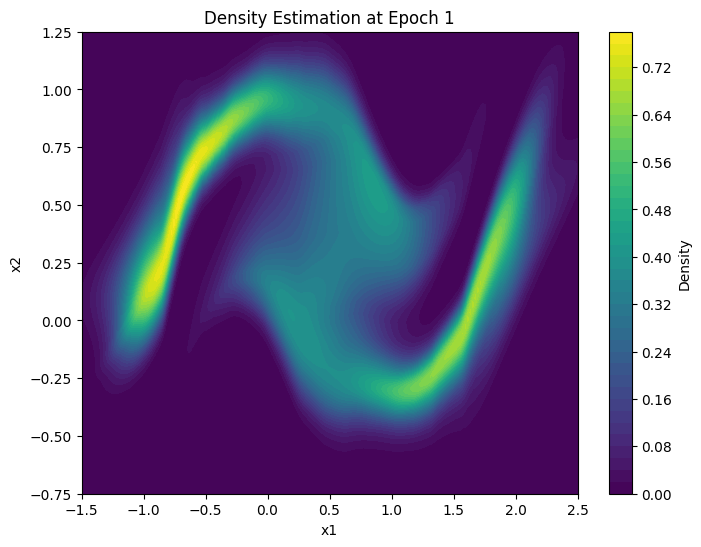

Epoch 100/500, Loss: 1.2898


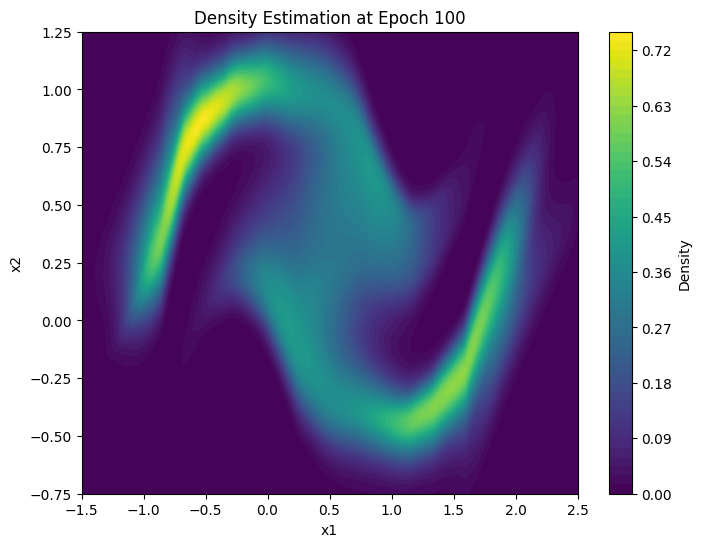

Epoch 200/500, Loss: 1.2172


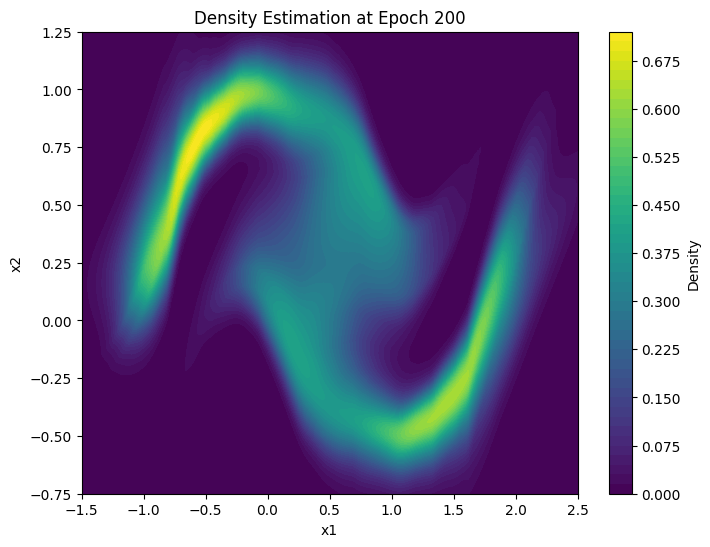

Epoch 300/500, Loss: 1.2848


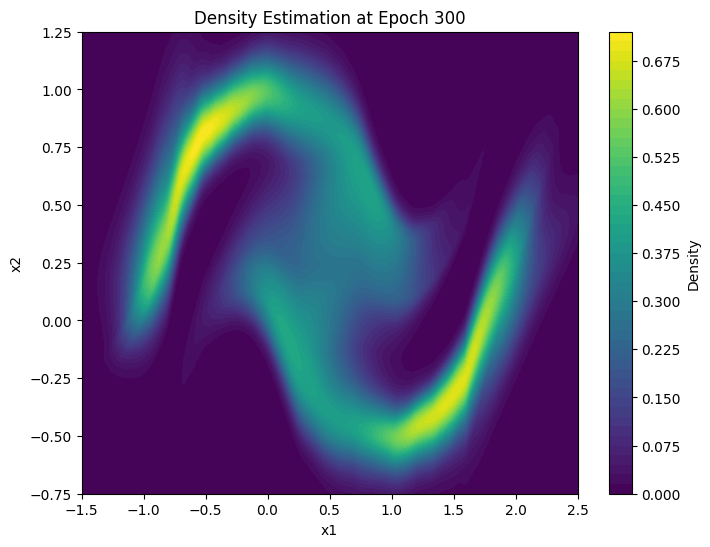

Epoch 400/500, Loss: 1.2871


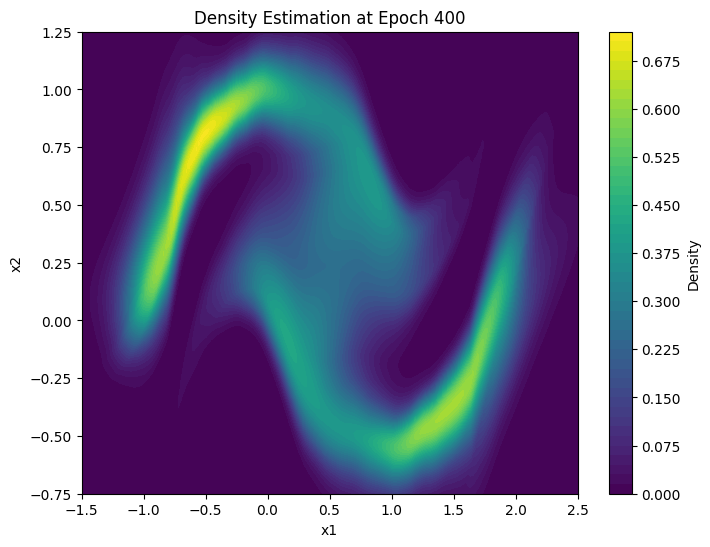

Epoch 500/500, Loss: 1.1979


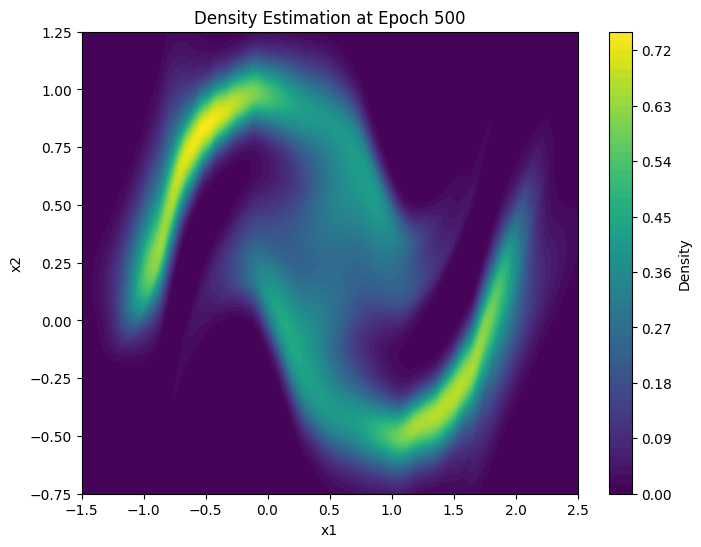

In [50]:
# Optimizer
optimizer = torch.optim.Adam(flow.parameters(), lr=learning_rate)

# Training loop
for epoch in range(1, num_epochs + 1):
    # Generate batch data
    batch_data, _ = make_moons(n_samples=batch_size, noise=0.1)
    batch_data = torch.tensor(batch_data, dtype=torch.float32, device=device)

    # Zero gradients, compute loss, and backpropagate
    optimizer.zero_grad()
    loss = -flow.log_prob(batch_data).mean()  # Negative log-likelihood
    loss.backward()
    optimizer.step()

    # Logging and visualization
    if epoch == 1 or epoch % 100 == 0:
        print(f"Epoch {epoch}/{num_epochs}, Loss: {loss.item():.4f}")

        # Visualization of learned density
        with torch.no_grad():
            grid_x = torch.linspace(-1.5, 2.5, 200, device=device)
            grid_y = torch.linspace(-0.75, 1.25, 200, device=device)
            mesh_x, mesh_y = torch.meshgrid(grid_x, grid_y, indexing="ij")
            grid_input = torch.cat([mesh_x.reshape(-1, 1), mesh_y.reshape(-1, 1)], dim=1)

            # Compute log probabilities and convert to density
            log_probs = flow.log_prob(grid_input).reshape(200, 200)
            density = torch.exp(log_probs).cpu().numpy()

        # Plot the density
        plt.figure(figsize=(8, 6))
        plt.contourf(
            mesh_x.cpu().numpy(),
            mesh_y.cpu().numpy(),
            density,
            levels=50,
            cmap="viridis"
        )
        plt.title(f'Density Estimation at Epoch {epoch}')
        plt.xlabel('x1')
        plt.ylabel('x2')
        plt.colorbar(label='Density')
        plt.show()


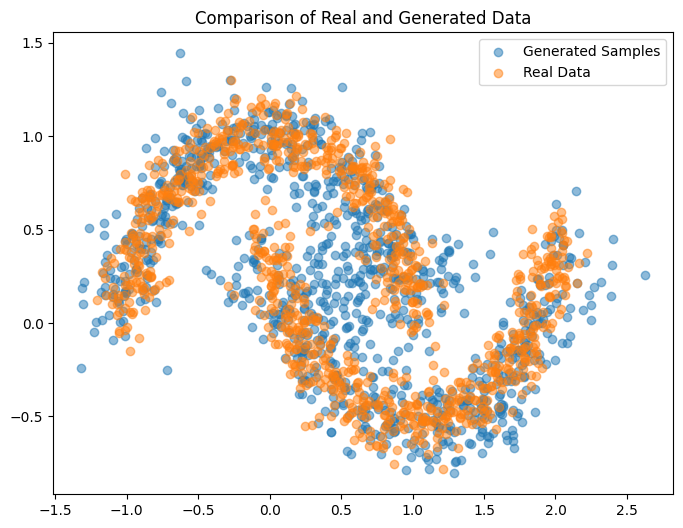

In [49]:
# Sampling from the flow
with torch.no_grad():
    samples = flow.sample(1000).cpu().numpy()
    x_real, _ = make_moons(1000, noise=0.1)  # Use make_moons from sklearn

    plt.figure(figsize=(8, 6))
    plt.scatter(samples[:, 0], samples[:, 1], alpha=0.5, label='Generated Samples')
    plt.scatter(x_real[:, 0], x_real[:, 1], alpha=0.5, label='Real Data')
    plt.legend()
    plt.title('Comparison of Real and Generated Data')
    plt.show()

# Section 2:Flows In Action

Here, we show how a flow can be trained to generate images with the `normflows` package. The flow is a [Glow](https://arxiv.org/abs/1807.03039) model, which is based on the [multi-scale architecture](https://arxiv.org/abs/1605.08803). This Glow model is applied to the MNIST dataset.

## Perparation

To get started, we have to install the `normflows` package.

In [15]:
!pip install normflows

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normflows: filename=normflows-1.7.3-py2.py3-none-any.whl size=87244 sha256=5a5cbb9302a2a90f4c08b01a2f6cd9c7b95ba50c71f0ca9d05a85c6787c00d6a
  Stored in directory: /root/.cache/pip/wheels/08/b1/a6/f018e29f12dc6251793263911d14764ddad0a6844f7b024007
Successfully built normflows


In [51]:
# Import required packages
import torch
import torchvision as tv
import numpy as np
import normflows as nf

from matplotlib import pyplot as plt
from tqdm import tqdm
import os

Glow consists of `nf.flows.GlowBlocks`, that are arranged in a `nf.MultiscaleFlow`, following the multi-scale architecture. The base distribution is a `nf.distributions.DiagGaussian`, which is a diagonal Gaussian.

In [52]:
# Define the directory to save checkpoints
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)


In [53]:
# Set up model (nothing TODO here)

# Define flows
L = 2
K = 16
torch.manual_seed(0)

input_shape = (1, 28, 28)
n_dims = np.prod(input_shape)
channels = 1
hidden_channels = 128
split_mode = 'channel'
scale = True

# Set up flows, distributions and merge operations
q0 = []
merges = []
flows = []
for i in range(L):
    flows_ = []
    for j in range(K):
        flows_ += [nf.flows.GlowBlock(channels * 2 ** (L + 1 - i), hidden_channels,
                                     split_mode=split_mode, scale=scale)]
    flows_ += [nf.flows.Squeeze()]
    flows += [flows_]
    if i > 0:
        merges += [nf.flows.Merge()]
        latent_shape = (input_shape[0] * 2 ** (L - i), input_shape[1] // 2 ** (L - i),
                        input_shape[2] // 2 ** (L - i))
    else:
        latent_shape = (input_shape[0] * 2 ** (L + 1), input_shape[1] // 2 ** L,
                        input_shape[2] // 2 ** L)
    q0 += [nf.distributions.DiagGaussian(latent_shape)]


# Construct flow model with the multiscale architecture
model = nf.MultiscaleFlow(q0, flows, merges)

In [54]:
# Move model on GPU if available
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [55]:
# @title loading MNIST dataset with TorchVision

batch_size = 128

transform = tv.transforms.Compose([tv.transforms.ToTensor(),
                                  #  nf.utils.Scale(255. / 256.),
                                   nf.utils.Jitter(1 / 256.)])

train_data = tv.datasets.MNIST('datasets/', train=True,
                                 download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True,
                                           drop_last=True)

test_data = tv.datasets.MNIST('datasets/', train=False,
                                download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

## Training

Now, can train the model on the image data. you can change this code to your prefered style as long as it is correct and the result is reasonable.

In [56]:
# Train model
max_iter = 10000
save_every = 2000  # Save every 2000 iterations

loss_hist = np.array([])

optimizer = torch.optim.Adamax(model.parameters(), lr=1e-3, weight_decay=1e-5)

train_iter = iter(train_loader)

for i in tqdm(range(max_iter)):

    optimizer.zero_grad()

    # Get a batch of data
    try:
        x, _ = next(train_iter)
    except StopIteration:
        train_iter = iter(train_loader)
        x, _ = next(train_iter)

    x = x.to(device)

    # Forward pass through the model and compute loss
    loss = model.forward_kld(x)  # Negative log likelihood

    # Backpropagation and optimization step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
       loss.backward()
       optimizer.step()

    loss_hist = np.append(loss_hist, loss.detach().to('cpu').numpy())

    if (i + 1) % save_every == 0:
        checkpoint_path = os.path.join(checkpoint_dir, f'model_iter_{i+1}.pth')
        torch.save({
            'iteration': i + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_hist': loss_hist,
        }, checkpoint_path)
        print(f'Checkpoint saved at iteration {i+1} to {checkpoint_path}')

    if (i + 1) % 500 == 0:
        max_grad = max(p.grad.abs().max().item() for p in model.parameters() if p.grad is not None)
        print(f"Iteration {i+1}: Max Gradient = {max_grad}")


  5%|▌         | 501/10000 [01:08<29:26,  5.38it/s]

Iteration 500: Max Gradient = 7884.529296875


 10%|█         | 1001/10000 [02:16<19:38,  7.64it/s]

Iteration 1000: Max Gradient = 32546.0859375


 15%|█▌        | 1501/10000 [03:24<18:03,  7.85it/s]

Iteration 1500: Max Gradient = 8836.15625


 20%|██        | 2001/10000 [04:32<22:00,  6.06it/s]

Checkpoint saved at iteration 2000 to checkpoints/model_iter_2000.pth
Iteration 2000: Max Gradient = 11247.982421875


 25%|██▌       | 2501/10000 [05:40<16:18,  7.66it/s]

Iteration 2500: Max Gradient = 53799.4453125


 30%|███       | 3001/10000 [06:48<14:50,  7.86it/s]

Iteration 3000: Max Gradient = 30422.462890625


 35%|███▌      | 3501/10000 [07:56<14:22,  7.53it/s]

Iteration 3500: Max Gradient = 11064.337890625


 40%|████      | 4001/10000 [09:03<15:47,  6.33it/s]

Checkpoint saved at iteration 4000 to checkpoints/model_iter_4000.pth
Iteration 4000: Max Gradient = 15017.845703125


 45%|████▌     | 4501/10000 [10:11<11:42,  7.83it/s]

Iteration 4500: Max Gradient = 48213.90625


 50%|█████     | 5001/10000 [11:19<11:03,  7.54it/s]

Iteration 5000: Max Gradient = 11517.2509765625


 55%|█████▌    | 5501/10000 [12:27<09:44,  7.69it/s]

Iteration 5500: Max Gradient = 20985.84765625


 60%|██████    | 6001/10000 [13:34<13:00,  5.12it/s]

Checkpoint saved at iteration 6000 to checkpoints/model_iter_6000.pth
Iteration 6000: Max Gradient = 23873.4375


 65%|██████▌   | 6501/10000 [14:42<08:04,  7.22it/s]

Iteration 6500: Max Gradient = 9869.794921875


 70%|███████   | 7001/10000 [15:49<06:20,  7.87it/s]

Iteration 7000: Max Gradient = 44006.9453125


 75%|███████▌  | 7501/10000 [16:56<05:36,  7.42it/s]

Iteration 7500: Max Gradient = 33056.80859375


 80%|████████  | 8001/10000 [18:04<05:30,  6.04it/s]

Checkpoint saved at iteration 8000 to checkpoints/model_iter_8000.pth
Iteration 8000: Max Gradient = 43562.375


 85%|████████▌ | 8501/10000 [19:11<03:17,  7.60it/s]

Iteration 8500: Max Gradient = 12311.2607421875


 90%|█████████ | 9001/10000 [20:18<02:11,  7.60it/s]

Iteration 9000: Max Gradient = 13061.466796875


 95%|█████████▌| 9501/10000 [21:26<01:10,  7.09it/s]

Iteration 9500: Max Gradient = 37394.42578125


100%|██████████| 10000/10000 [22:33<00:00,  7.39it/s]

Checkpoint saved at iteration 10000 to checkpoints/model_iter_10000.pth
Iteration 10000: Max Gradient = 11305.1123046875


In [57]:
# Save the final model after training
final_checkpoint_path = os.path.join(checkpoint_dir, 'model_final.pth')
torch.save({
    'iteration': max_iter,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss_hist': loss_hist,
}, final_checkpoint_path)
print(f'Final model saved to {final_checkpoint_path}')

Final model saved to checkpoints/model_final.pth


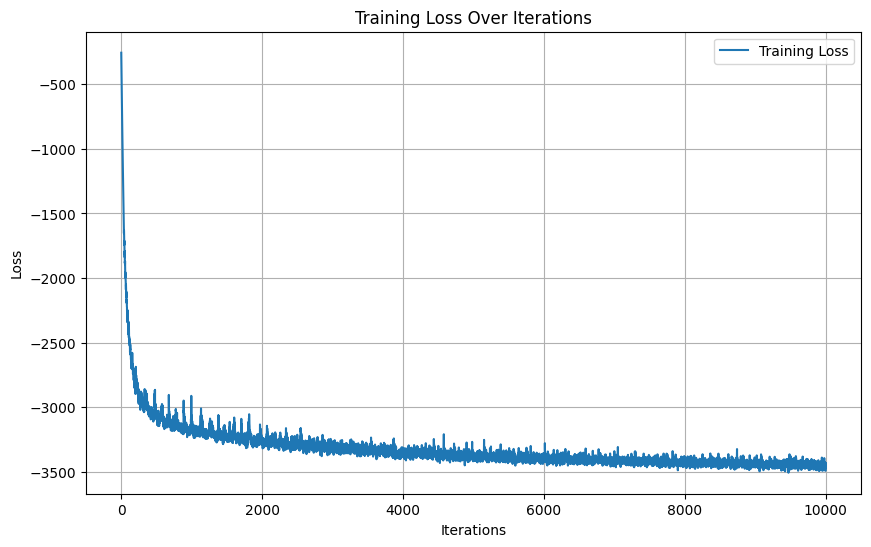

In [58]:
# TODO Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(loss_hist, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Over Iterations')
plt.legend()
plt.grid()
plt.show()

## Evaluation

To evaluate our model, we can just draw samples from our model.

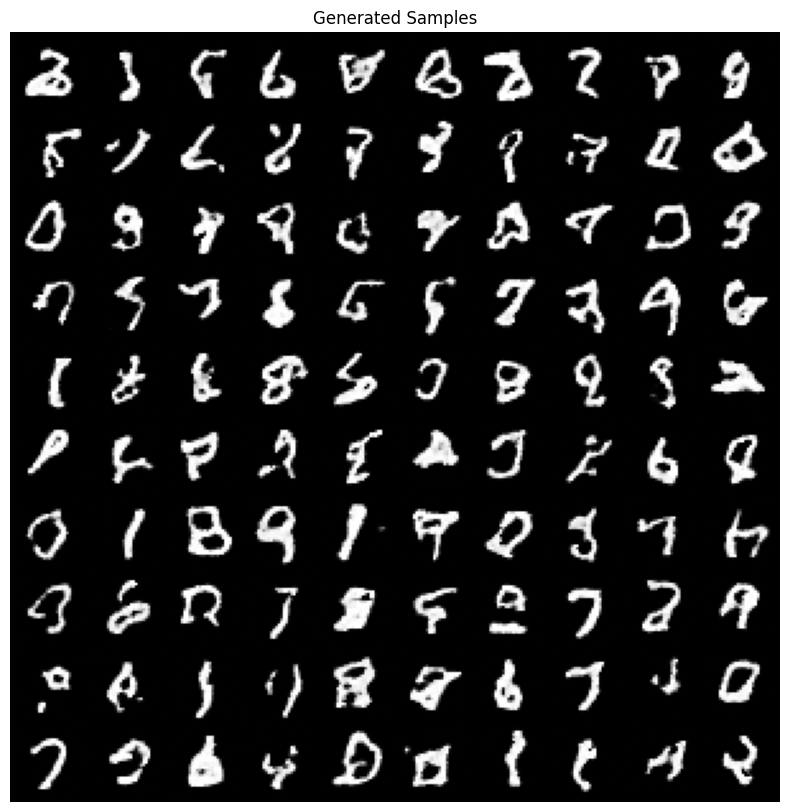

In [69]:
# Model samples
num_samples_per_grid = 10  # Number of samples per grid row
total_samples = num_samples_per_grid * num_samples_per_grid  # Total samples to generate


with torch.no_grad():
    try:
        # Sample from the base distribution
        x, _ = model.sample(num_samples_per_grid ** 2)  # No class labels needed
    except torch.linalg.LinAlgError as e:
        print("Encountered a singular matrix during sampling. Adjusting regularization...")
        # Optional: Regularize or attempt resampling here
        model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
        x, _ = model.sample(num_samples_per_grid ** 2)

    x_ = torch.clamp(x, 0, 1)

    # Arrange samples in a grid
    grid = tv.utils.make_grid(x_, nrow=num_samples_per_grid)

    # Plot the grid of samples
    plt.figure(figsize=(10, 10))
    plt.imshow(np.transpose(grid.cpu().numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title('Generated Samples')
    plt.show()


Note that to get competitive performance, a much larger model than specified in this notebook, which is trained over more iterations, is needed.

## In-Painting

In [60]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
import torch.optim as optim

Now you are supposed to create a function that masks a random square of the image, and a function that fills the missing part based on maximum liklihood using the trained flow model.

In [71]:
def apply_random_square_mask(image, mask_size=8):
    """
    Applies a random square mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        mask_size (int): Size of the square mask.

    Returns:
        masked_image (torch.Tensor): Image with the masked square.
        mask (torch.Tensor): Binary mask indicating masked regions (1 for masked).
    """
    _, H, W = image.shape
    top_left_x = np.random.randint(0, W - mask_size + 1)
    top_left_y = np.random.randint(0, H - mask_size + 1)

    # Create binary mask
    mask = torch.zeros((H, W), dtype=torch.float32)
    mask[top_left_y:top_left_y + mask_size, top_left_x:top_left_x + mask_size] = 1.0

    # Apply the mask to the image (assuming 0 as the masking value)
    masked_image = image.clone()
    masked_image[:, top_left_y:top_left_y + mask_size, top_left_x:top_left_x + mask_size] = 0.0

    return masked_image, mask


In [72]:
# @title Optional random noise mask
def apply_random_noise_mask(image, noise_fraction=0.2):
    """
    Applies a random noise mask to the input image.

    Args:
        image (torch.Tensor): Input image tensor of shape [C, H, W].
        noise_fraction (float): Fraction of pixels to replace with noise.

    Returns:
        masked_image (torch.Tensor): Image with noise added.
        mask (torch.Tensor): Binary mask indicating noise regions (1 for noise).
    """
    masked_image = image.clone()
    mask = torch.zeros_like(image[0])  # Single channel mask

    C, H, W = image.shape
    num_pixels = H * W
    num_noise = int(noise_fraction * num_pixels)

    # Random indices
    noise_indices = np.random.choice(num_pixels, num_noise, replace=False)
    noise_coords = np.unravel_index(noise_indices, (H, W))

    # Apply noise
    for c in range(C):
        noise = torch.rand(num_noise) * 2 - 1  # Random noise in [-1, 1]
        masked_image[c, noise_coords[0], noise_coords[1]] = noise
    mask[noise_coords[0], noise_coords[1]] = 1.0

    return masked_image, mask


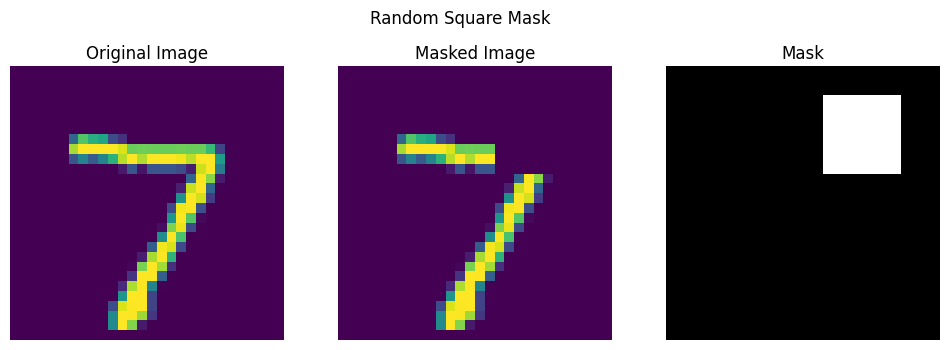

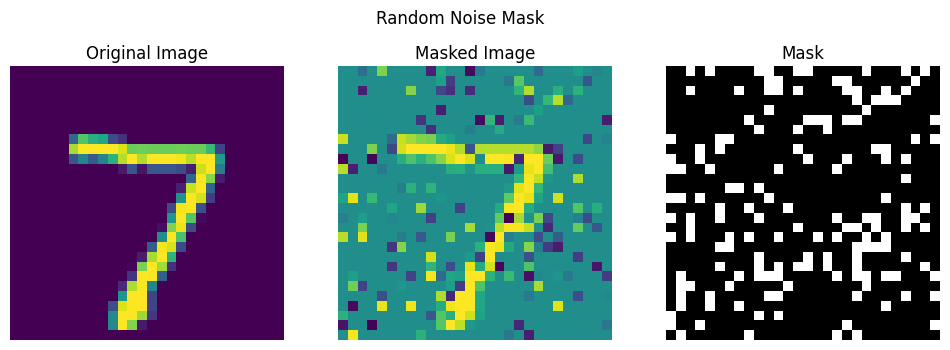

In [73]:
def visualize_masking(original_image, masked_image, mask, title="Masking Example"):
    """
    Visualizes the original, masked images and the mask.

    Args:
        original_image (torch.Tensor): Original image tensor [C, H, W].
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask [H, W].
        title (str): Title for the plot.
    """
    original = original_image.permute(1, 2, 0).cpu().numpy()
    masked = masked_image.permute(1, 2, 0).cpu().numpy()
    mask_display = mask.cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original Image")
    axs[0].axis('off')

    axs[1].imshow(masked)
    axs[1].set_title("Masked Image")
    axs[1].axis('off')

    axs[2].imshow(mask_display, cmap='gray')
    axs[2].set_title("Mask")
    axs[2].axis('off')

    plt.suptitle(title)
    plt.show()

# Example usage
# Assuming `sample_image` is a tensor [C, H, W] from your dataset
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]  # Take the first image

masked_image_square, mask_square = apply_random_square_mask(sample_image, mask_size=8)
visualize_masking(sample_image, masked_image_square, mask_square, title="Random Square Mask")

masked_image_noise, mask_noise = apply_random_noise_mask(sample_image, noise_fraction=0.2)
visualize_masking(sample_image, masked_image_noise, mask_noise, title="Random Noise Mask")

In [74]:
def inpaint_image(model, masked_image, mask, device, num_steps=1000, lr=0.1):
    """
    Inpaints the masked regions of an image by maximizing the log-likelihood under the flow model.

    Args:
        model (nn.Module): Trained normalizing flow model.
        masked_image (torch.Tensor): Masked image tensor [C, H, W].
        mask (torch.Tensor): Binary mask tensor [H, W], 1 for masked pixels.
        device (torch.device): Device for computations.
        num_steps (int): Number of optimization steps.
        lr (float): Learning rate for the optimizer.

    Returns:
        inpainted_image (torch.Tensor): Inpainted image tensor [C, H, W].
    """
    model.eval()  # Set model to evaluation mode

    # Clone the masked image to avoid modifying the original
    inpainted_image = masked_image.clone().to(device).unsqueeze(0)  # Shape [1, C, H, W]
    mask = mask.unsqueeze(0).unsqueeze(0).to(device)  # Shape [1, 1, H, W]

    # Initialize missing pixels to random noise for the masked regions
    missing_pixels = torch.zeros_like(inpainted_image).to(device)
    missing_pixels[mask.bool()] = torch.rand_like(missing_pixels[mask.bool()])

    # Make missing_pixels a learnable parameter
    missing_pixels = torch.nn.Parameter(missing_pixels)

    # Define optimizer
    optimizer = torch.optim.Adam([missing_pixels], lr=lr)

    for step in tqdm(range(num_steps), desc="Inpainting"):
        optimizer.zero_grad()

        # Reconstruct the full image by combining observed and missing pixels
        full_image = inpainted_image.clone()
        full_image[mask.bool()] = missing_pixels[mask.bool()]

        # Compute log-likelihood loss
        loss = model.forward_kld(full_image)  # Using forward_kld for log-likelihood
        loss = -loss.mean()  # Negating as we want to maximize log-likelihood
        loss.backward()

        optimizer.step()

        # Clamp the missing pixels to valid range (e.g., [0, 1])
        with torch.no_grad():
            missing_pixels.data.clamp_(0.0, 1.0)

        if (step + 1) % 100 == 0:
            print(f"Step [{step+1}/{num_steps}], Loss: {loss.item():.4f}")

    # After optimization, insert missing_pixels into inpainted_image
    with torch.no_grad():
        inpainted_image[mask.bool()] = missing_pixels[mask.bool()]

    return inpainted_image.squeeze(0)


In [90]:
# Example usage with a batch of 4 images
batch_size = 4
sample_images, sample_labels = next(iter(test_loader))
sample_images = sample_images[:batch_size]
sample_labels = sample_labels[:batch_size]

# Apply random square masks to the batch
masked_images = []
masks = []
inpainted_images = []

for img in sample_images:
    masked_img, mask = apply_random_square_mask(img, mask_size=8)
    masked_images.append(masked_img)
    masks.append(mask)
    inpainted_images.append(inpaint_image(model, masked_img, mask, device, num_steps=50, lr=0.005))

masked_images = torch.stack(masked_images)
masks = torch.stack(masks)
inpainted_images = torch.stack(inpainted_images)

Inpainting: 100%|██████████| 50/50 [00:05<00:00,  9.49it/s]


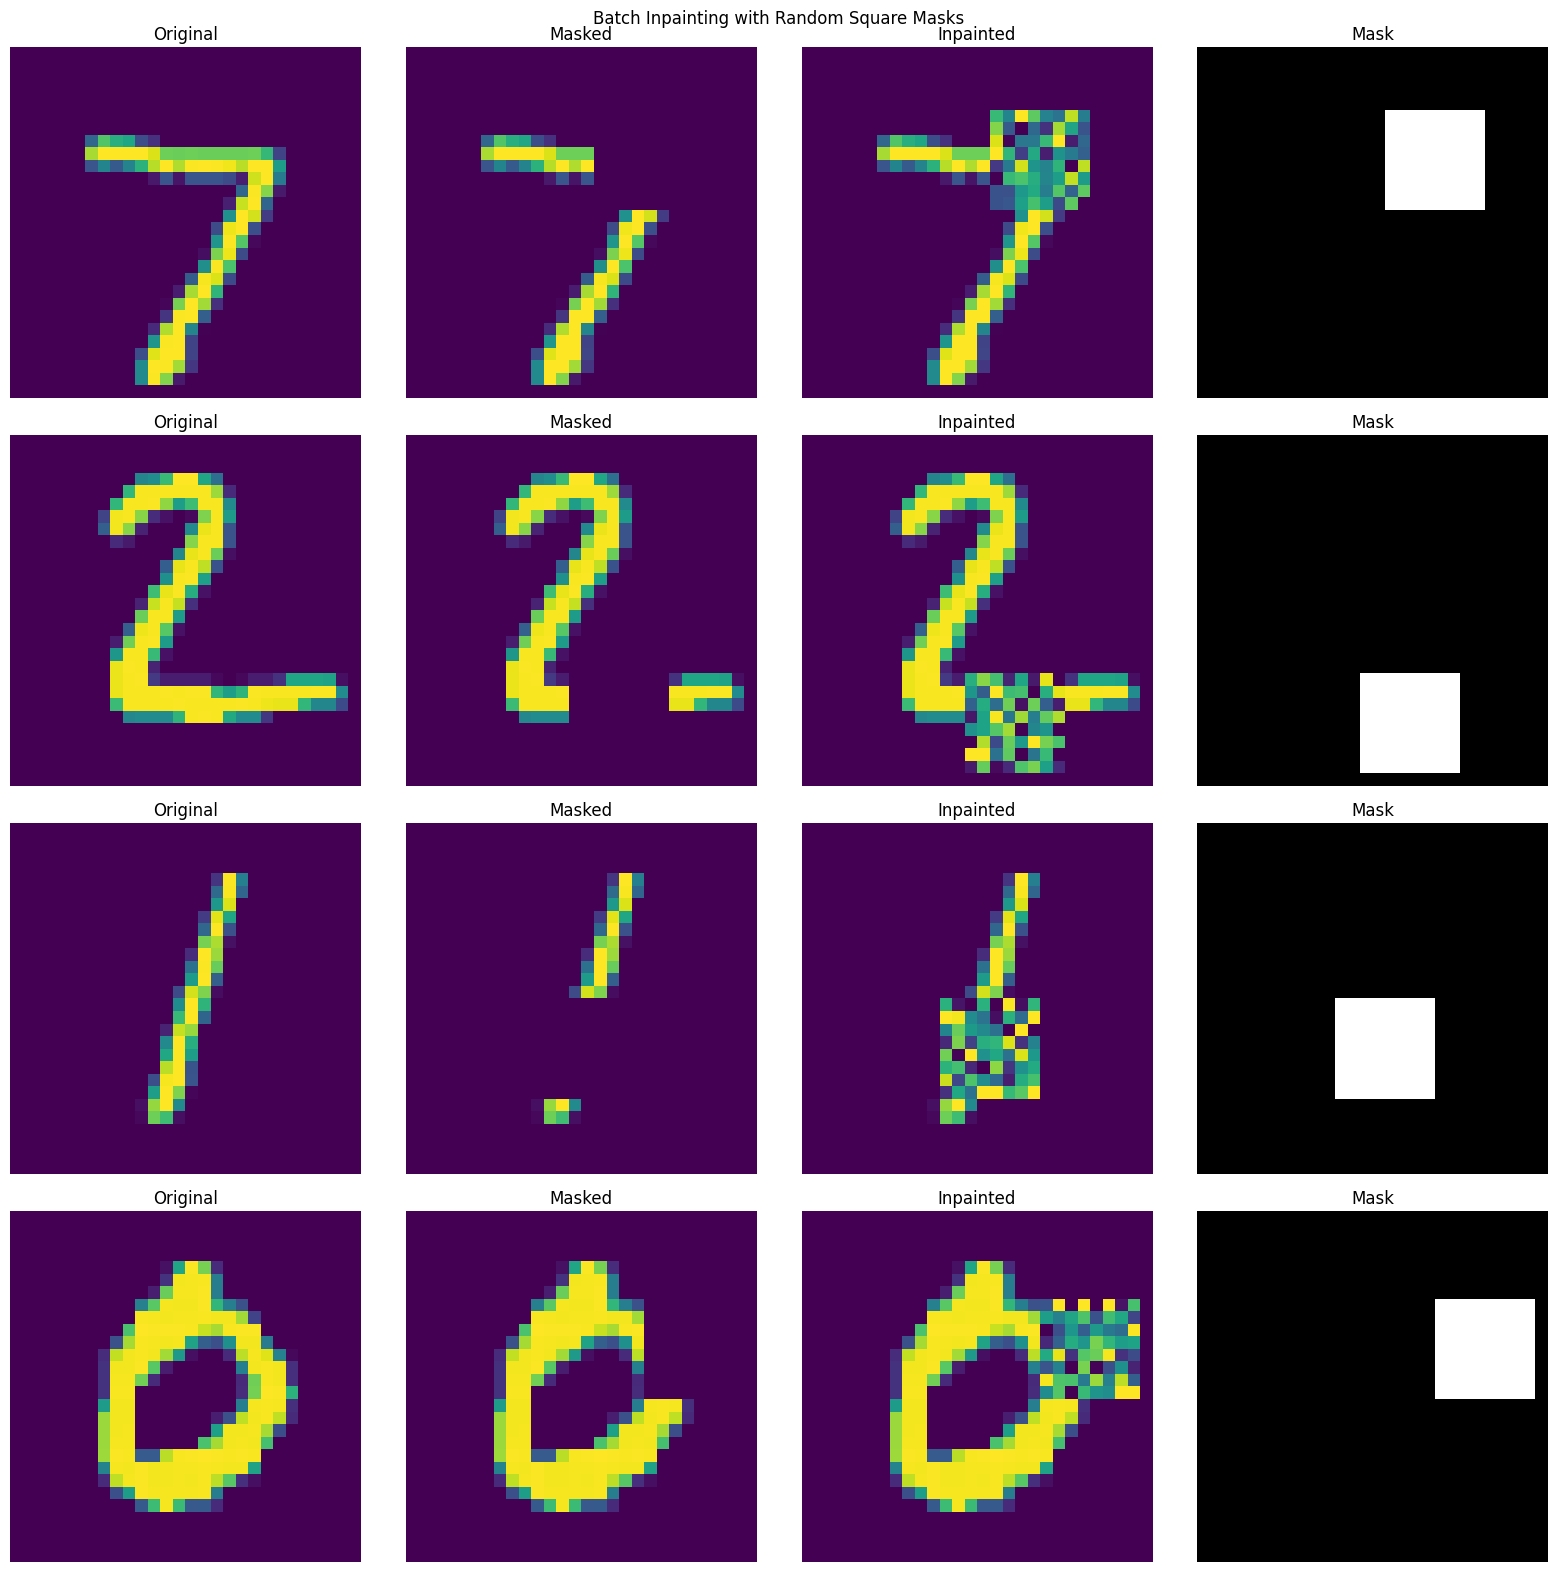

In [91]:
# Visualize the results (this is a suggested code, you can change this)
def visualize_batch_inpainting(originals, masked, inpainted, masks, title="Batch Inpainting Results"):
    """
    Visualizes a batch of original, masked, and inpainted images with their masks.

    Args:
        originals (torch.Tensor): Original images [N, C, H, W].
        masked (torch.Tensor): Masked images [N, C, H, W].
        inpainted (torch.Tensor): Inpainted images [N, C, H, W].
        masks (torch.Tensor): Masks [N, H, W].
        title (str): Title for the plot.
    """
    N = originals.size(0)
    fig, axs = plt.subplots(N, 4, figsize=(16, 4 * N))

    for i in range(N):

        original = originals[i].permute(1, 2, 0).detach().cpu().numpy()
        masked_img = masked[i].permute(1, 2, 0).detach().cpu().numpy()
        inpainted_img = inpainted[i].permute(1, 2, 0).detach().cpu().numpy()
        mask_display = masks[i].detach().cpu().numpy()

        axs[i, 0].imshow(original)
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        axs[i, 1].imshow(masked_img)
        axs[i, 1].set_title("Masked")
        axs[i, 1].axis('off')

        axs[i, 2].imshow(inpainted_img)
        axs[i, 2].set_title("Inpainted")
        axs[i, 2].axis('off')

        axs[i, 3].imshow(mask_display, cmap='gray')
        axs[i, 3].set_title("Mask")
        axs[i, 3].axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_batch_inpainting(sample_images, masked_images, inpainted_images, masks, title="Batch Inpainting with Random Square Masks")
